In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [8]:
import corner
import emcee3
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.stats import LombScargle

In [3]:
import celerite
from celerite import terms

from cerotate.k2 import get_light_curve
from cerotate.rotation_term import RotationTerm

In [108]:
# t, flux = get_light_curve(1, 201497682)
t, flux = get_light_curve(2, 205117205)
# t, flux = get_light_curve(3, 205943030)
# t, flux = get_light_curve(7, 219128753)
# t, flux = get_light_curve(8, 220684009)

6.2495311914


/Users/dfm/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


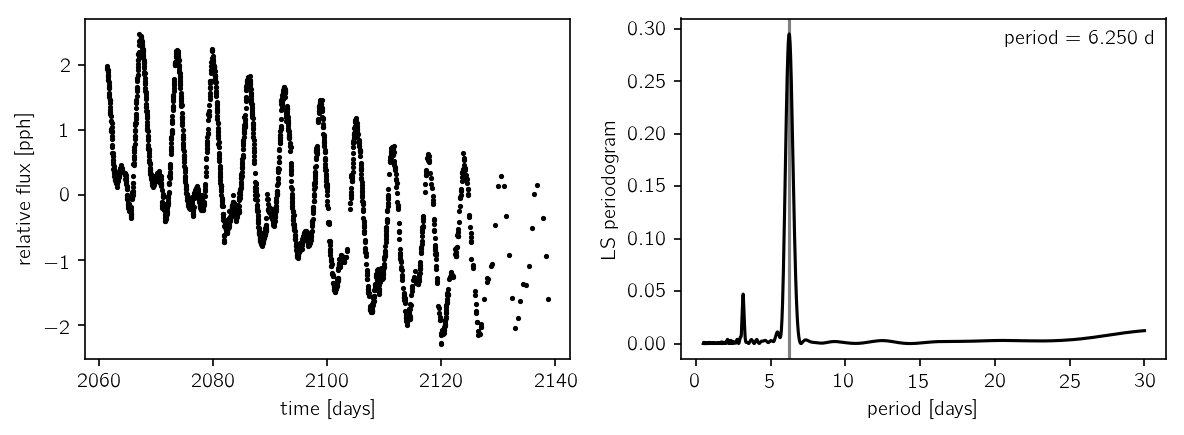

In [109]:
# First guess at the period
freq = np.linspace(1.0 / 30.0, 1.0 / 0.5, 5000)
model = LombScargle(t, flux)
power = model.power(freq, method="fast", normalization="psd")
power /= len(t)

period = 1.0 / freq[np.argmax(power)]
print(period)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(t, flux, ".k", ms=3)
axes[0].set_ylabel("relative flux [pph]")
axes[0].set_xlabel("time [days]")

axes[1].plot(1.0 / freq, power, "k")
axes[1].axvline(period, color="k", alpha=0.5)
axes[1].set_xlabel("period [days]")
axes[1].set_ylabel("LS periodogram")
axes[1].annotate("period = {0:.3f} d".format(period), xy=(1, 1), xycoords="axes fraction",
                 ha="right", va="top", xytext=(-5, -5), textcoords="offset points")

fig.set_tight_layout(True)

      fun: -3854.2992133348453
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.94885816e-04,   1.36117226e-03,  -3.32780356e-03,
         1.36153626e-02,   1.74951577e-04,  -3.79261683e+01,
        -1.10735095e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 73
      nit: 59
   status: 0
  success: True
        x: array([ 2.31396881,  3.20184417, -4.64676075,  1.83682998, -2.54615975,
        1.14472989, -3.49756673])


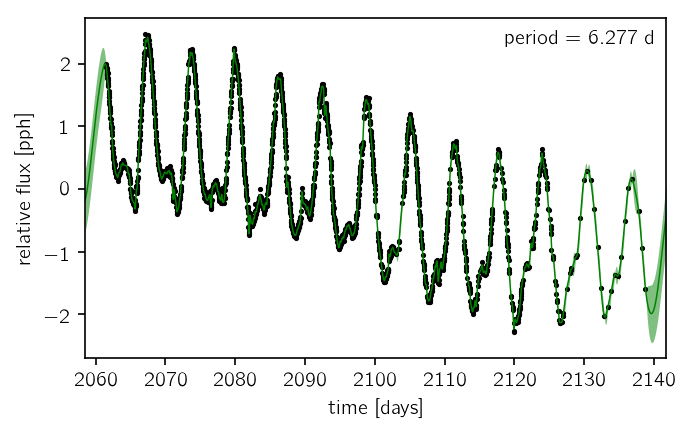

In [110]:
log_var = np.log(np.var(flux))
kernel = RotationTerm(
    log_a=log_var,
    log_b=-0.1,
    log_f=-5.0,
    log_P=np.log(period),
    bounds=dict(
        log_a=(-10.0, 10.0),
        log_b=(-5.0, 5.0),
        log_f=(-5.0, 5.0),
        log_P=(np.log(0.5), np.log(30)),
    ),
)

kernel += terms.SHOTerm(
    log_S0=log_var,
    log_Q=-0.5*np.log(2),
    log_omega0=np.log(2*np.pi/10.0),
    bounds=dict(
        log_S0=(-20.0, 20.0),
        log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0))
    )
)
kernel.terms[1].freeze_parameter("log_Q")

kernel += terms.JitterTerm(log_sigma=np.log(np.median(np.abs(np.diff(flux)))),
                           bounds=[(-10.0, 10.0)])
gp = celerite.GP(kernel)
gp.compute(t)

def nll(params):
    gp.set_parameter_vector(params)
    try:
        return -gp.log_likelihood(flux)
    except celerite.solver.LinAlgError:
        return 1e10

def grad_nll(params):
    gp.set_parameter_vector(params)
    try:
        return -gp.grad_log_likelihood(flux)[1]
    except celerite.solver.LinAlgError:
        return np.zeros_like(params)

bounds = gp.get_parameter_bounds()
p0 = gp.get_parameter_vector()
soln = minimize(nll, p0, jac=grad_nll, method="L-BFGS-B", bounds=bounds)
print(soln)

x = np.linspace(t.min() - 3, t.max() + 3, 5000)
pred_mu, pred_var = gp.predict(flux, x, return_var=True)
pred_sig = np.sqrt(pred_var)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t, flux, ".k", ms=3)
ax.plot(x, pred_mu, "g", lw=0.7)
ax.fill_between(x, pred_mu+pred_sig, pred_mu-pred_sig, color="g",
                alpha=0.5, lw=0)
ax.set_ylabel("relative flux [pph]")
ax.set_xlabel("time [days]")
ax.set_xlim(x.min(), x.max())

ml_period = np.exp(gp.kernel.terms[0].log_P)
ax.annotate("period = {0:.3f} d".format(ml_period),
            xy=(1, 1), xycoords="axes fraction",
            ha="right", va="top", xytext=(-5, -5), textcoords="offset points");

In [111]:
def log_prob(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    try:
        return lp + gp.log_likelihood(flux)
    except celerite.solver.LinAlgError:
        return -np.inf

ndim = len(soln.x)
nwalkers = 64
pos = soln.x + 1e-5 * np.random.randn(nwalkers, ndim)
lp = np.array(list(map(log_prob, pos)))
m = ~np.isfinite(lp)
while np.any(m):
    pos[m] = soln.x + 1e-5 * np.random.randn(m.sum(), ndim)
    lp[m] = np.array(list(map(log_prob, pos[m])))
    m = ~np.isfinite(lp)
    
sampler = emcee3.Sampler([
    emcee3.moves.StretchMove(),
    emcee3.moves.DEMove(1e-3),
    emcee3.moves.KDEMove(),
])  #, backend=emcee3.backends.HDFBackend("astero-{0}.h5".format(epicid)))

with emcee3.pools.InterruptiblePool() as pool:
    ensemble = emcee3.Ensemble(emcee3.SimpleModel(log_prob), pos,
                               pool=pool)
    ensemble = sampler.run(ensemble, 5000, progress=True)

100%|██████████| 5000/5000 [02:58<00:00, 27.99it/s]


Final c is 5


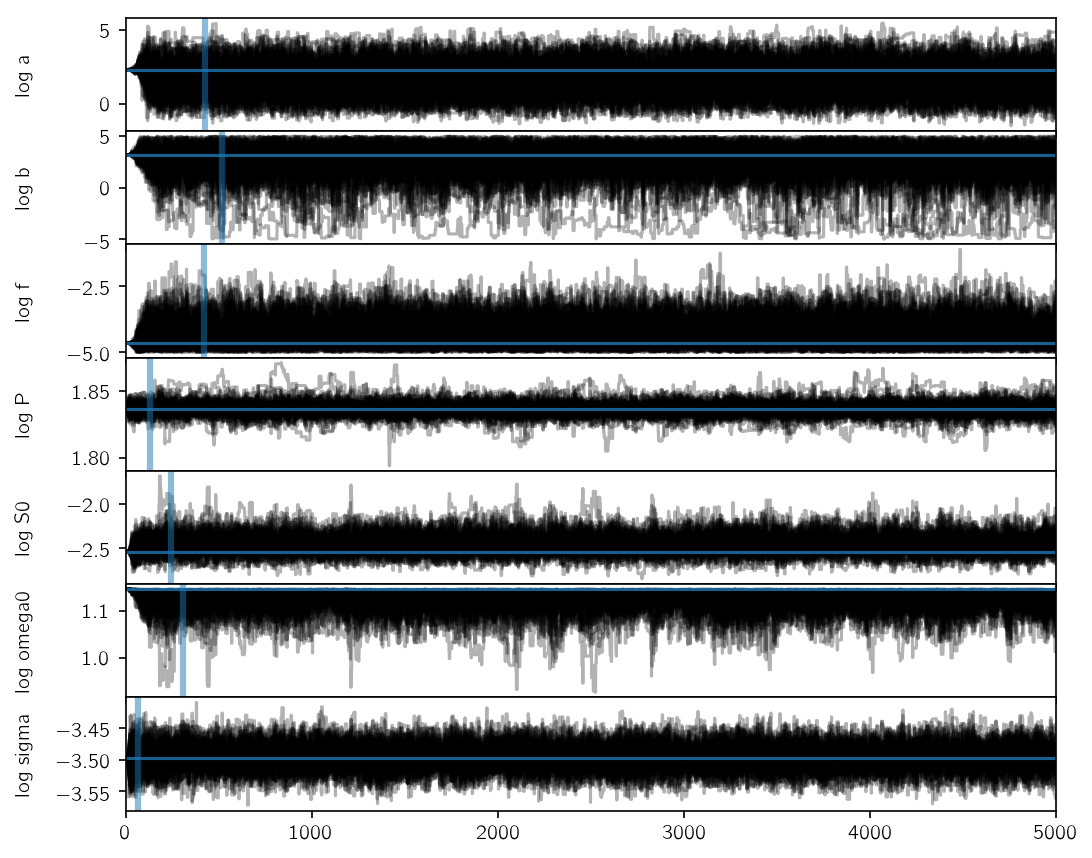

In [112]:
for c in range(5, 0, -1):
    try:
        tau = sampler.get_integrated_autocorr_time(c=c)
    except emcee3.autocorr.AutocorrError:
        continue
    print("Final c is {0}".format(c))
    break
chain = sampler.get_coords()
names = gp.get_parameter_names()
names = [n.split(":")[-1].replace("_", " ") for n in names]
ndim = chain.shape[-1]

fig, axes = plt.subplots(ndim, 1, figsize=(8, ndim*1), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chain))
    ax.set_ylabel(names[i])
    ax.axvline(5*tau[i], alpha=0.5, lw=3)
    ax.axhline(soln.x[i], alpha=0.8)
    ax.yaxis.set_label_coords(-0.1, 0.5)

fig.subplots_adjust(hspace=0)

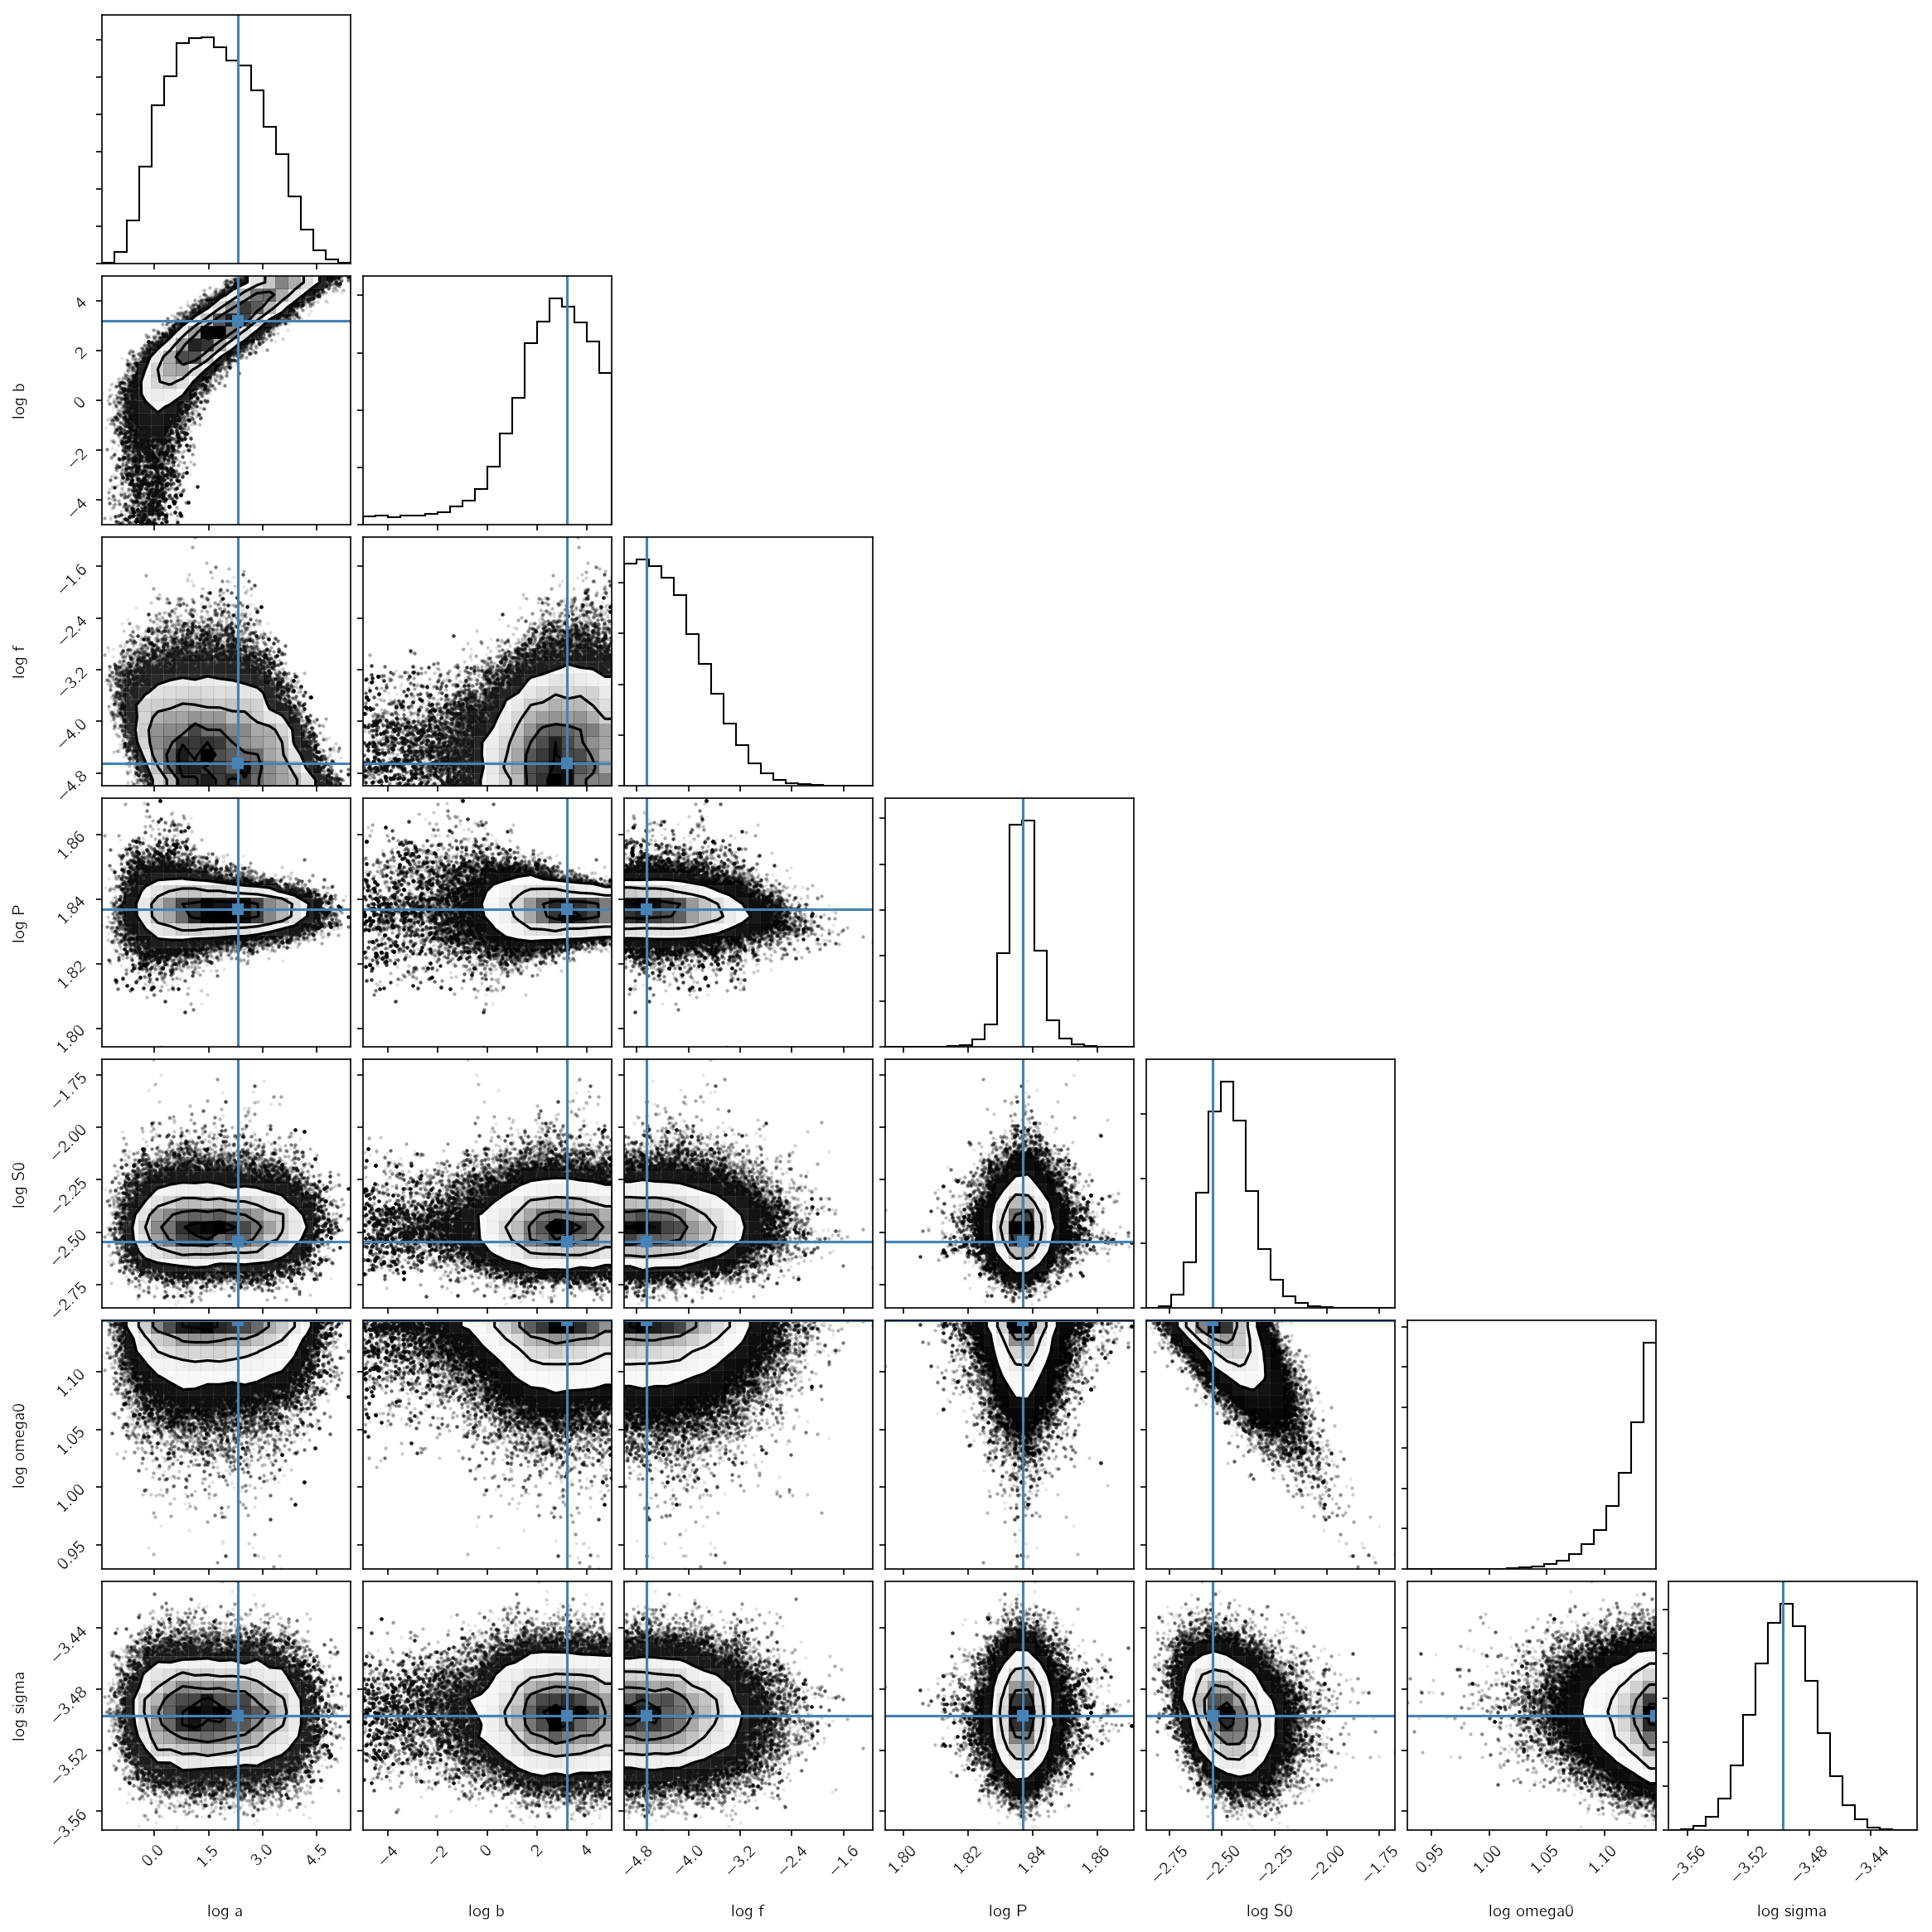

In [113]:
samples = sampler.get_coords(flat=True, discard=int(tau[3]*5))
corner.corner(samples, truths=soln.x, labels=names);

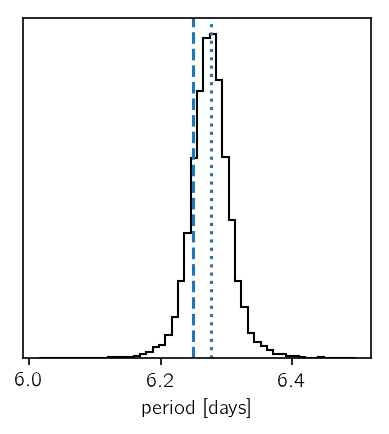

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.hist(np.exp(samples[:, 3]), 50, color="k", histtype="step")
ax.axvline(period, ls="--")
ax.axvline(ml_period, ls=":")
ax.set_yticks([])
ax.set_xlabel("period [days]");

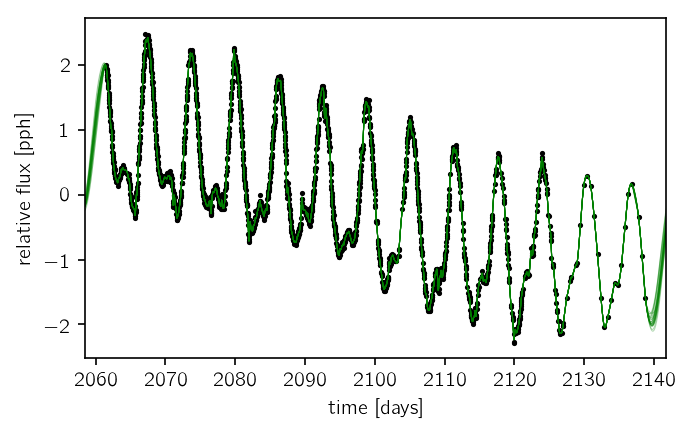

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t, flux, ".k", ms=3)

tau = np.linspace(0, 30, 5000)
for s in samples[np.random.randint(len(samples), size=25)]:
    gp.set_parameter_vector(s)
    ax.plot(x, gp.predict(flux, x, return_cov=False), "g", alpha=0.3, lw=0.5)

ax.set_ylabel("relative flux [pph]")
ax.set_xlabel("time [days]")
ax.set_xlim(x.min(), x.max());